In [44]:
#this whole section is full only of method functions of the SinglePartUnitaryChain class
#a lot of these functions are holdovers or unused so this cell is better used as a reference 
#for when functions are found below. Make sure to run before running everything else, though.
import numpy as np
import copy
import scipy
from scipy.linalg import expm
from scipy.optimize import curve_fit
import time as t
import matplotlib.pyplot as plt
np.set_printoptions(precision=2, linewidth=100)

#this class sets up an instance of a unitary evolution
#if you want to change system size, create a different object
class SinglePartUnitaryChain:
    def __init__(self,L,w, BC = 1):
        if L%2 != 0:
            print("Invalid choice of L, make it an even integer.")
            return
        #L is system size, combining A and B sites
        self.L = L
        
        self.clearAll()
        #self.U = np.identity(L, dtype = 'complex') this is set during the previous line
        
        #w is the default width of the disorder distribution (the distribution is uniform, but if you
        #want a different distribution, just create a different function).
        self.w = w

        #this gives the boundary conditions, if BC is 1 it is periodic, if it is 0 it is open
        self.BC = BC
        
        #this is the periodic position operator and is needed to calculate localization length
        self.rx = np.diag(np.vectorize(lambda x: np.exp(2j*np.pi * x/(self.L)))(np.arange(self.L)))
    
    #this function prints an image of the current status of the unitary
    def showU(self, window=-1, showEval = -1):
        if not window + 1:
            window = self.L
        #use to check that you're preserving unitarity
        #print(np.linalg.det(self.U))
        out,sub = plt.subplots(1,2)
        sub[0].set_title("Real")
        sub[0].imshow(np.real(self.U[:window,:window]),cmap = plt.cm.bwr, norm=plt.Normalize(-1,1))
        sub[1].set_title("Imaginary")
        sub[1].imshow(np.imag(self.U[:window,:window]),cmap = plt.cm.bwr, norm=plt.Normalize(-1,1))
        if showEval+1:
            out1,sub1 = plt.subplots(1)
            sub1.set_title("Eigenvalue")
            sub1.plot(np.real(self.Evects[showEval]))
    
    #this is a swap between A and B sites "onsite"
    #the default time is the full pi/2 evolution of the drive
    def step1Rud(self, tee = np.pi/2):
        UT = np.zeros((self.L,self.L), dtype = complex)
        for i in range(0-self.BC*self.L//2,self.L-self.BC*self.L//2):
            if not i&1 and i != self.L-1:
                UT[i+1,i] = 1j*np.sin(tee)
                UT[i,i+1] = 1j*np.sin(tee)
                UT[i,i] = np.cos(tee)
                UT[i+1,i+1] = np.cos(tee)
        self.U = self.U @ UT
    
    #this is a swap between B and A sites "between sites"
    #the default time is the full pi/2 evolution of the drive
    def step2Rud(self, tee = np.pi/2):
        UT = np.eye(self.L, dtype = complex)
        for i in range(0-self.BC*self.L//2,self.L-self.BC*self.L//2):
            if i&1 and i != self.L-1:
                UT[i+1,i] = 1j*np.sin(tee)
                UT[i,i+1] = 1j*np.sin(tee)
                UT[i,i] = np.cos(tee)
                UT[i+1,i+1] = np.cos(tee)
        self.U = self.U @ UT

    #the onsite disorder step, if not given a strength of distribution, uses self.w
    #if you want a different distribution, for now, copy this method and change that aspect
    def Dstep(self, width = None):
        if width == None:
            width = self.w
        UD = np.zeros((self.L,self.L), dtype = complex)
        for n in range(self.L):
            UD[n,n] = np.exp(1j*np.random.uniform(0,width))
        self.UD = UD
        self.U = UD @ self.U
    
    #this does the opposite of the last used self.Dstep
    def inverseDstep(self):
        self.U = self.U @ np.conjugate(self.UD)
    
    #this does a random unitary evolution that is translationally invariant that mixes onsite
    #by inputting the parameters, you can do any specific numerical unitary, otherwise it picks a random one
    def step1T(self, seedAngle=None, seedPhase1=None, seedPhase2=None):
        L = self.L
        print("U1 arguments: theta, phiDiag, phiOffdiag")
        if seedAngle==None:
            seedAngle = np.random.uniform(-np.pi,np.pi)
        print(seedAngle)
        if seedPhase1==None:
            seedPhase1 = np.random.uniform(-np.pi,np.pi)
        print(seedPhase1)
        if seedPhase2==None:
            seedPhase2 = np.random.uniform(-np.pi,np.pi)
        print(seedPhase2)
        U1 = np.zeros((L,L), dtype = 'complex')
        U1[0,0] = 1
        U1[-1,-1] = 1
        for i in range(0-self.BC*self.L//2,self.L-self.BC*self.L//2):
            if not i&1:
                U1[i,i+1] = np.exp(1j*seedPhase2)*np.sin(seedAngle)
                U1[i+1,i] = -np.exp(-1j*seedPhase2)*np.sin(seedAngle)
                U1[i,i] = np.exp(1j*seedPhase1)*np.cos(seedAngle)
                U1[i+1,i+1] = np.exp(-1j*seedPhase1)*np.cos(seedAngle)
        self.U = self.U @ U1
    
    #this does a random unitary evolution that is translationally invariant that mixes between sites
    #by inputting the parameters, you can do any specific numerical unitary, otherwise it picks a random one
    def step2T(self, seedAngle=None, seedPhase1=None, seedPhase2=None):
        L = self.L
        print("U2 arguments: theta, phiDiag, phiOffdiag")
        if seedAngle==None:
            seedAngle = np.random.uniform(-np.pi,np.pi)
        print(seedAngle)
        if seedPhase1==None:
            seedPhase1 = np.random.uniform(-np.pi,np.pi)
        print(seedPhase1)
        if seedPhase2==None:
            seedPhase2 = np.random.uniform(-np.pi,np.pi)
        print(seedPhase2)
        U2 = np.zeros((L,L), dtype = 'complex')
        U2[0,0] = 1
        U2[-1,-1] = 1
        for i in range(0-self.BC*self.L//2,self.L-self.BC*self.L//2):
            if i&1 and i != self.L-1:
                U2[i,i+1] = np.exp(1j*seedPhase2)*np.sin(seedAngle)
                U2[i+1,i] = -np.exp(-1j*seedPhase2)*np.sin(seedAngle)
                U2[i,i] = np.exp(1j*seedPhase1)*np.cos(seedAngle)
                U2[i+1,i+1] = np.exp(-1j*seedPhase1)*np.cos(seedAngle)
        self.U = self.U @ U2
    
    #this does a random unitary evolution random across the whole system that mixes neighboring same sublattice
    #if you want one parameter disorder, just pass it one parameter, or none and it'll use self.w
    def stepLongD(self, seedAngleStrength=None, seedPhase1Strength=None, seedPhase2Strength=None, seedPhase3Strength=None):
        L = self.L
        #print("LongD argument strengths: theta, phiDiag, phiOffdiag, phiOverall")
        if seedAngleStrength==None:
            seedAngleStrength = self.w
        #print(seedAngleStrength)
        if seedPhase1Strength==None:
            seedPhase1Strength = seedAngleStrength
        #print(seedPhase1Strength)
        if seedPhase2Strength==None:
            seedPhase2Strength = seedPhase1Strength
        #print(seedPhase2Strength)
        if seedPhase3Strength==None:
            seedPhase3Strength = seedAngleStrength
        #print(seedPhase3Strength)
        D1 = np.zeros((L,L), dtype = 'complex')
        for i in range(0-self.BC*self.L//4,self.L//2-self.BC*self.L//4):
            if not i&1:
                Angle = np.random.uniform(-seedAngleStrength,seedAngleStrength)
                Phase1 = np.random.uniform(-seedPhase1Strength,seedPhase1Strength)
                Phase2 = np.random.uniform(-seedPhase2Strength,seedPhase2Strength)
                Phase3 = np.random.uniform(-seedPhase3Strength,seedPhase3Strength)
                D1[2*i,2*i+2] = np.exp(1j*(Phase2+Phase3/2))*np.sin(Angle)
                D1[2*i+2,2*i] = -np.exp(-1j*(Phase2-Phase3/2))*np.sin(Angle)
                D1[2*i,2*i] = np.exp(1j*(Phase1+Phase3/2))*np.cos(Angle)
                D1[2*i+2,2*i+2] = np.exp(-1j*(Phase1-Phase3/2))*np.cos(Angle)
            if i&1:
                Angle = np.random.uniform(-seedAngleStrength,seedAngleStrength)
                Phase1 = np.random.uniform(-seedPhase1Strength,seedPhase1Strength)
                Phase2 = np.random.uniform(-seedPhase2Strength,seedPhase2Strength)
                Phase3 = np.random.uniform(-seedPhase3Strength,seedPhase3Strength)
                D1[2*i-1,2*i+1] = np.exp(1j*(Phase2+Phase3/2))*np.sin(Angle)
                D1[2*i+1,2*i-1] = -np.exp(-1j*(Phase2-Phase3/2))*np.sin(Angle)
                D1[2*i-1,2*i-1] = np.exp(1j*(Phase1+Phase3/2))*np.cos(Angle)
                D1[2*i+1,2*i+1] = np.exp(-1j*(Phase1-Phase3/2))*np.cos(Angle)
        self.DL = D1
        self.U = self.U @ D1
    
    #this does a random unitary evolution random across the whole system that mixes onsite
    #if you want one parameter disorder, just pass it one parameter, or none and it'll use self.w
    def step1D(self, seedAngleStrength=None, seedPhase1Strength=None, seedPhase2Strength=None, visual=False):
        L = self.L
        print("D1 argument strengths: theta, phiDiag, phiOffdiag")
        if seedAngleStrength==None:
            seedAngleStrength = self.w
        print(seedAngleStrength)
        if seedPhase1Strength==None:
            seedPhase1Strength = seedAngleStrength
        print(seedPhase1Strength)
        if seedPhase2Strength==None:
            seedPhase2Strength = seedPhase1Strength
        print(seedPhase2Strength)
        D1 = np.zeros((L,L), dtype = 'complex')
        D1[0,0] = 1
        D1[-1,-1] = 1
        for i in range(0,L-1):
            if not i&1:
                Angle = np.random.uniform(0,seedAngleStrength)
                Phase1 = np.random.uniform(0,seedPhase1Strength)
                Phase2 = np.random.uniform(0,seedPhase2Strength)
                D1[i,i+1] = np.exp(1j*Phase2)*np.sin(Angle)
                D1[i+1,i] = -np.exp(-1j*Phase2)*np.sin(Angle)
                D1[i,i] = np.exp(1j*Phase1)*np.cos(Angle)
                D1[i+1,i+1] = np.exp(-1j*Phase1)*np.cos(Angle)
        #you can set the visual parameter to True to print an image of the unitary
        if visual:
            out,sub = plt.subplots(1)
            sub.set_title("Real")
            sub.imshow(np.real(D1[0:20,0:20]),cmap = plt.cm.bwr, norm=plt.Normalize(-1,1))
            out1,sub1 = plt.subplots(1)
            sub1.set_title("Imaginary")
            sub1.imshow(np.imag(D1[0:20,0:20]),cmap = plt.cm.bwr, norm=plt.Normalize(-1,1))
        self.D1 = D1
        self.U = self.U @ D1
    
    #this does a random unitary evolution random across the whole system that mixes onsite
    #if you want one parameter disorder, just pass it one parameter, or none and it'll use self.w
    def step2D(self, seedAngleStrength=None, seedPhase1Strength=None, seedPhase2Strength=None, visual=False):
        L = self.L
        print("D2 argument strengths: theta, phiDiag, phiOffdiag")
        if seedAngleStrength==None:
            seedAngleStrength = self.w
        print(seedAngleStrength)
        if seedPhase1Strength==None:
            seedPhase1Strength = seedAngleStrength
        print(seedPhase1Strength)
        if seedPhase2Strength==None:
            seedPhase2Strength = seedPhase1Strength
        print(seedPhase2Strength)
        D2 = np.zeros((L,L), dtype = 'complex')
        D2[0,0] = 1
        D2[-1,-1] = 1
        for i in range(0,L-1):
            if i&1:
                Angle = np.random.uniform(0,seedAngleStrength)
                Phase1 = np.random.uniform(0,seedPhase1Strength)
                Phase2 = np.random.uniform(0,seedPhase2Strength)
                D2[i,i+1] = np.exp(1j*Phase2)*np.sin(Angle)
                D2[i+1,i] = -np.exp(-1j*Phase2)*np.sin(Angle)
                D2[i,i] = np.exp(1j*Phase1)*np.cos(Angle)
                D2[i+1,i+1] = np.exp(-1j*Phase1)*np.cos(Angle)
        #you can set the visual parameter to True to print an image of the unitary
        if visual:
            out,sub = plt.subplots(1)
            sub.set_title("Real")
            sub.imshow(np.real(D2[0:20,0:20]),cmap = plt.cm.bwr, norm=plt.Normalize(-1,1))
            out1,sub1 = plt.subplots(1)
            sub1.set_title("Imaginary")
            sub1.imshow(np.imag(D2[0:20,0:20]),cmap = plt.cm.bwr, norm=plt.Normalize(-1,1))
        self.D2 = D2
        self.U = self.U @ D2
    
    #this is the prototype generic unitary for onsite sites
    def step1exp(self, tee, t1, onsiteA, onsiteB, Phase, visual=False):
        L = self.L
        H1 = np.zeros((L,L), dtype = 'complex')
        for i in range(0,L-1):
            if not i&1:
                H1[i,i] = onsiteA
                H1[i+1,i+1] = onsiteB
                H1[i,i+1] = np.exp(1j*Phase)*t1
                H1[i+1,i] = np.exp(-1j*Phase)*t1
        #after exponentiating once, the unitary with the same time period is saved
        self.U1 = expm(1j*tee*H1)
        self.U = self.U @ self.U1
    
    #this is the prototype generic unitary between sites
    def step2exp(self, tee, t1, onsiteA, onsiteB, Phase, visual=False):
        L = self.L
        H2 = np.zeros((L,L), dtype = 'complex')
        for i in range(0,L-1):
            if i&1:
                H2[i,i] = onsiteB
                H2[i+1,i+1] = onsiteA
                H2[i,i+1] = np.exp(1j*Phase)*t1
                H2[i+1,i] = np.exp(-1j*Phase)*t1
        #after exponentiating once, the unitary with the same time period is saved
        self.U2 = expm(1j*tee*H2)
        self.U = self.U @ self.U2
    
    #this does the opposite of the last used spatially random unitary onsite
    def inverse1D(self):
        self.U = self.U @ np.transpose(np.conj(self.D1))
    
    #this does the opposite of the last used spatially random unitary between sites
    def inverse2D(self):
        self.U = self.U @ np.transpose(np.conj(self.D2))
    
    #this does the opposite of the last used random long unitary
    def inverseLongD(self):
        self.U = self.U @ np.transpose(np.conj(self.DL))
    
    #this function implements and sets up the ones below to create a loop with random couplings
    def CreateLoopReturn(self, h, DisordType = 0, verbose = False):
        temp = t.time()
        self.clearAll()
        self.randomCouplings(h)
        if DisordType == 0:
            self.step1RudDfixed()
            self.step2RudDfixed(np.pi)
            self.step1RudDfixed()
        elif DisordType == 1:
            self.step1RudDfixedAlt()
            self.step2RudDfixedAlt(np.pi)
            self.step1RudDfixedAlt()
        elif DisordType == 2:
            self.step1RudDfixedAlt2()
            self.step2RudDfixedAlt2(np.pi)
            self.step1RudDfixedAlt2()
        elif DisordType == 3:
            self.step1Rud()
            self.step2RudDfixedAlt2(np.pi)
            self.step1Rud()
        elif DisordType == 4:
            self.step1Rud()
            self.step2RudDfixed(np.pi)
            self.step1Rud()
        self.U = np.transpose(np.conj(self.U))
        self.calculateEspace(v=False,timed=False)
        self.H3 = np.transpose(self.Evects)@np.diag((self.Evals)**(.5))@np.linalg.inv(np.transpose(self.Evects))
        self.U = self.H3
        if verbose:
            print("Creating the return unitary took " + str(t.time() - temp) + " seconds.")
    
    #this rolls a set of random perturbations to the couplings for the coupling disorder
    #run this once at the beginning of the drive
    def randomCouplings(self, h = .01):
        self.couplings = np.zeros(self.L)
        for i in range(self.L):
            delta = np.random.normal(scale = h)
            self.couplings[i] = 1 + delta
    
    #this is the same as the swap evolution, but with the theta multiplicative perturbed couplings
    #make sure to run self.randomCouplings before using this evolution
    def step1RudDfixed(self, tee = np.pi/2):
        UT = np.zeros((self.L,self.L), dtype = complex)
        for i in range(0-self.BC*self.L//2,self.L-self.BC*self.L//2):
            if not i&1 and i != self.L-1:
                UT[i+1,i] = 1j*np.sin(tee*self.couplings[i])
                UT[i,i+1] = 1j*np.sin(tee*self.couplings[i])
                UT[i,i] = np.cos(tee*self.couplings[i])
                UT[i+1,i+1] = np.cos(tee*self.couplings[i])
        self.U = self.U @ UT
    
    #this is the same as the swap evolution, but with the theta multiplicative perturbed couplings
    #make sure to run self.randomCouplings before using this evolution
    def step2RudDfixed(self, tee = np.pi/2):
        UT = np.zeros((self.L,self.L), dtype = complex)
        UT[0,0] = 1
        UT[-1,-1] = 1
        for i in range(0-self.BC*self.L//2,self.L-self.BC*self.L//2):
            if i&1 and (i != self.L-1 or self.BC):
                UT[i+1,i] = 1j*np.sin(tee*self.couplings[i])
                UT[i,i+1] = 1j*np.sin(tee*self.couplings[i])
                UT[i,i] = np.cos(tee*self.couplings[i])
                UT[i+1,i+1] = np.cos(tee*self.couplings[i])
        self.U = self.U @ UT
        
    #this is the same as the swap evolution, but with the additively perturbed couplings
    #make sure to run self.randomCouplings before using this evolution
    def step1RudDfixedAlt(self, tee = np.pi/2):
        UT = np.zeros((self.L,self.L), dtype = complex)
        for i in range(0-self.BC*self.L//2,self.L-self.BC*self.L//2):
            if not i&1 and i != self.L-1:
                UT[i+1,i] = 1j*np.sin(tee + 1 - self.couplings[i])
                UT[i,i+1] = 1j*np.sin(tee + 1 - self.couplings[i])
                UT[i,i] = np.cos(tee + 1 - self.couplings[i])
                UT[i+1,i+1] = np.cos(tee + 1 - self.couplings[i])
        self.U = self.U @ UT
    
    #this is the same as the swap evolution, but with the additively perturbed couplings
    #make sure to run self.randomCouplings before using this evolution
    def step2RudDfixedAlt(self, tee = np.pi/2):
        UT = np.zeros((self.L,self.L), dtype = complex)
        UT[0,0] = 1
        UT[-1,-1] = 1
        for i in range(0-self.BC*self.L//2,self.L-self.BC*self.L//2):
            if i&1 and (i != self.L-1 or self.BC):
                UT[i+1,i] = 1j*np.sin(tee + 1 - self.couplings[i])
                UT[i,i+1] = 1j*np.sin(tee + 1 - self.couplings[i])
                UT[i,i] = np.cos(tee + 1 - self.couplings[i])
                UT[i+1,i+1] = np.cos(tee + 1 - self.couplings[i])
        self.U = self.U @ UT
    
    #this is the same as the swap evolution, but with the tau multiplicative perturbed couplings
    #make sure to run self.randomCouplings before using this evolution
    def step1RudDfixedAlt2(self, tee = np.pi/2):
        UT = np.zeros((self.L,self.L), dtype = complex)
        for i in range(0-self.BC*self.L//2,self.L-self.BC*self.L//2):
            if not i&1 and i != self.L-1:
                UT[i+1,i] = 1j*np.sin(tee + (1-self.couplings[i])*np.abs(np.pi/2 - tee))
                UT[i,i+1] = 1j*np.sin(tee + (1-self.couplings[i])*np.abs(np.pi/2 - tee))
                UT[i,i] = np.cos(tee + (1-self.couplings[i])*np.abs(np.pi/2 - tee))
                UT[i+1,i+1] = np.cos(tee + (1-self.couplings[i])*np.abs(np.pi/2 - tee))
        self.U = self.U @ UT
    
    #this is the same as the swap evolution, but with the tau multiplicative perturbed couplings
    #make sure to run self.randomCouplings before using this evolution
    def step2RudDfixedAlt2(self, tee = np.pi/2):
        UT = np.zeros((self.L,self.L), dtype = complex)
        UT[0,0] = 1
        UT[-1,-1] = 1
        for i in range(0-self.BC*self.L//2,self.L-self.BC*self.L//2):
            if i&1 and (i != self.L-1 or self.BC):
                UT[i+1,i] = 1j*np.sin(tee + (1-self.couplings[i])*np.abs(np.pi/2 - tee))
                UT[i,i+1] = 1j*np.sin(tee + (1-self.couplings[i])*np.abs(np.pi/2 - tee))
                UT[i,i] = np.cos(tee + (1-self.couplings[i])*np.abs(np.pi/2 - tee))
                UT[i+1,i+1] = np.cos(tee + (1-self.couplings[i])*np.abs(np.pi/2 - tee))
        self.U = self.U @ UT
    
    #this is the alternative to the methods above, each evolution is another random
    #perturbation to the couplings; generally this is way too disruptive
    def step1RudDwild(self, tee = np.pi/2, h = .01):
        UT = np.zeros((self.L,self.L), dtype = complex)
        for i in range(0,self.L-1):
            if not i&1:
                delta = np.random.normal(scale = h)
                UT[i+1,i] = 1j*np.sin(tee + delta)
                UT[i,i+1] = 1j*np.sin(tee + delta)
                UT[i,i] = np.cos(tee + delta)
                UT[i+1,i+1] = np.cos(tee + delta)
        self.U = self.U @ UT
    
    #this is the alternative to the methods above, each evolution is another random
    #perturbation to the couplings; generally this is way too disruptive
    def step2RudDwild(self, tee = np.pi/2, h = .01):
        UT = np.zeros((self.L,self.L), dtype = complex)
        for i in range(0,self.L-1):
            UT[0,0] = 1
            UT[-1,-1] = 1
            if i&1:
                delta = np.random.normal(scale = h)
                UT[i+1,i] = 1j*np.sin(tee + delta)
                UT[i,i+1] = 1j*np.sin(tee + delta)
                UT[i,i] = np.cos(tee + delta)
                UT[i+1,i+1] = np.cos(tee + delta)
        self.U = self.U @ UT
    
    #this evolves with the translation operator by a number of sites equal to delta
    def translateStep(self, delta = 1):
        UT = np.zeros((self.L,self.L), dtype = complex)
        UT = np.diag(np.ones(self.L-delta),-delta) + np.diag(np.ones(delta),self.L-delta)
        self.U = self.U @ UT
    
    #this is as above but only translates A sites to A sites
    def translateStepA(self, delta = 1):
        UT = np.zeros((self.L,self.L), dtype = complex)
        for i in range(-self.L//2,self.L//2):
            if not i&1:
                UT[i+2*delta,i] = 1
            else:
                UT[i,i] = 1
        self.U = self.U @ UT
    
    #this is as above but only translates B sites to B sites
    def translateStepB(self, delta = 1):
        UT = np.zeros((self.L,self.L), dtype = complex)
        for i in range(-self.L//2,self.L//2):
            if i&1:
                UT[i,i+2*delta] = 1
            else:
                UT[i,i] = 1
        self.U = self.U @ UT
    
    #this resets most of the stored info in this object
    def clearAll(self):
        self.U = np.identity(self.L, dtype = 'complex')
        self.Evals = None
        self.qEvals = None
        self.Evects = None
        
    #a diagnostic function to look at just the eigenvalues without solving the vectors
    def SpectTest(self):
        #use just to test that everything's working correctly
        E = np.linalg.eigvals(self.U)
        print(E)
        print(np.absolute(E))
    
    #This is a very important funtion
    #Any time you want to calculate something after changing the unitary,
    #you run this function to calculate and store the new states and eigenvalues
    def calculateEspace(self, v=True, timed=True):
        if timed:
            temp = t.time()
        eigentemp = np.linalg.eig(self.U)
        self.Evals = eigentemp[0]
        self.qEvals = np.angle(eigentemp[0])
        self.Evects = np.transpose(eigentemp[1])
        #this next line sorts everything by the quasieigenvalues
        self.qEvals, self.Evals, self.Evects = zip(*sorted(zip(self.qEvals, self.Evals, self.Evects), key=lambda x: x[0]))
        self.qEvals = np.array(self.qEvals)
        self.Evals = np.array(self.Evals)
        if timed:
            print("Calculation took " + str(t.time() - temp) + " seconds.")
        if v:
            print("Eigenspace calculated. self.Evals holds eigenvalues, self.qEvals holds their respective quasi-energies, and self.Evects holds the eigenstates.")
    
    #shows the distribution of eigenvalues around the unit circle
    def qEscatterplot(self):
        out, sub = plt.subplots(1)
        sub.set_aspect(1.0)
        sub = plt.scatter(np.real(self.Evals),np.imag(self.Evals))
    
    #finds the center of mass of either one or all eigenfunctions
    def findCOM(self, index=-.5):
        if not(index+.5):
            out = []
            for n in range(self.L):
                i = int(np.rint(self.L/(2*np.pi) * np.imag(np.log(np.vdot(self.Evects[n], np.dot(self.rx, self.Evects[n]))))))
                out.append(i)
            return out
        else:
            if index == int(index) and abs(index + .5)<self.L:
                i = int(np.rint(self.L/(2*np.pi) * np.imag(np.log(np.vdot(self.Evects[index], np.dot(self.rx, self.Evects[index]))))))
                return i
            else:
                print("findCOM passed bad index")
                return
    
    #finds the localization length of one or all eigenfunctions
    def locLength(self, index = -.5):
        if self.Evects==None:
            print("Remember to run the drive and calculate the eigenstates first.")
            return
        if not(index+.5):
            loclens = np.zeros(self.L)
            centers = self.findCOM()
            for n in range(self.L):
                wf = np.roll(self.Evects[n],-centers[n])
                for i in range(-self.L//2,self.L//2):
                    loclens[n] += np.absolute(i)*(np.absolute(wf[i])**2)
            return loclens
        else:
            if index == int(index) and abs(index + .5)<self.L**2:
                loclen = 0
                center = self.findCOM(index)
                for i in range(self.L):
                    loclen += np.absolute(center-i)*(np.absolute(self.Evects[index][i])**2)
                return loclen
            else:
                print("locLength passed bad index")
                return
            
print("done")
        

done


In [47]:
#This creates a whole data set, maybe not the best for first use.
#Skip to below where the cell says "Tutorial"

#For this cell input
#a set of system size lengths to cover
#the number of disorder realizations for each system size respectively
#the number of time steps to cover
#how much of step 2 to skip over (its total time length is np.pi/2)
#how close to the critical time you want to get
#usually don't change w
#h is only for additional forms of disorder

Llist = [100,200,400]
dlist = [15,8,3]
tsteps = 8
tskip = 1.1
tendskip = .1
delT = (np.pi/2 - tskip - tendskip)/tsteps
tpoints = np.linspace(np.pi/2 - tskip, tendskip, tsteps + 1)
wlist = [np.pi]*len(Llist)
h = 0
runIdent = str(t.time())[:10]

#this is the array that all the output data will be stored in
allAveLocLens = np.zeros((tsteps+1, len(Llist)))

for l in range(len(Llist)):
    temp = t.time()
    for d in range(dlist[l]):
        print("starting instance " + str(d+1) + " for length " + str(Llist[l]))
        system = SinglePartUnitaryChain(Llist[l],wlist[l])
        #system.CreateLoopReturn(h)
        #system.stepLongD()
        system.Dstep()
        
        for tee in range(tsteps+1):
            system.U = system.UD
            system.step1Rud()
            system.step2Rud(tskip + tee*delT)
            
            system.calculateEspace(v=False,timed=False)
            lens = system.locLength()
            val = np.mean(lens)
            allAveLocLens[tee][l] += val/dlist[l]
            file_name1 = "lengths_T_" + str(tpoints[tee]) + "0_L_" + str(Llist[l]) + "_run_"+ runIdent + "_W_" + str(wlist[l]) + ".txt"
            f1 = open(file_name1,'a')
            f1.write(str(lens) + " ")
            f1.close()
    print("Length " + str(Llist[l]) + " took " + str(t.time()-temp) + " seconds.")

starting instance 1 for length 100
starting instance 2 for length 100
starting instance 3 for length 100
starting instance 4 for length 100
starting instance 5 for length 100
starting instance 6 for length 100
starting instance 7 for length 100
starting instance 8 for length 100
starting instance 9 for length 100
starting instance 10 for length 100
starting instance 11 for length 100
starting instance 12 for length 100
starting instance 13 for length 100
starting instance 14 for length 100
starting instance 15 for length 100
Length 100 took 13.002527713775635 seconds.
starting instance 1 for length 200
starting instance 2 for length 200
starting instance 3 for length 200
starting instance 4 for length 200
starting instance 5 for length 200
starting instance 6 for length 200
starting instance 7 for length 200
starting instance 8 for length 200
Length 200 took 24.71286416053772 seconds.
starting instance 1 for length 400
starting instance 2 for length 400
starting instance 3 for length 4

In [50]:
#Run this if you have to force quit out of running the previous cell to stop any loose ends
f1.close()

[[11.68 15.51 15.19]
 [12.96 17.49 19.29]
 [14.42 20.28 23.44]
 [15.83 23.05 29.55]
 [17.26 26.67 35.88]
 [18.68 30.32 44.38]
 [20.19 34.53 55.51]
 [21.68 39.09 67.42]
 [23.1  43.15 79.78]]
[0.47 0.42 0.38 0.33 0.29 0.24 0.19 0.15 0.1 ]
[[-0.52 -0.8  -1.27]
 [ 2.14  2.22  1.9 ]]


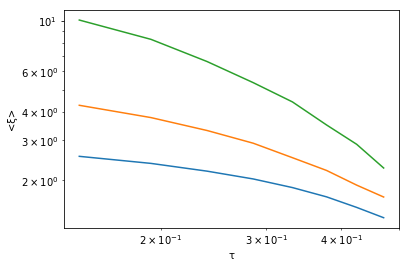

In [48]:
#this plots at each time step the data collected above as well as prints it and fits it
#of the array that is the fit, the first one is the slope and the second one is the intercept

begin = 0
end = -1
fig, ax = plt.subplots(1)
print(allAveLocLens)
print(tpoints)
fittt = np.polyfit(np.log(tpoints)[begin:end],np.log(allAveLocLens[begin:end]),1)
print(fittt)
ax.set_xlabel("τ")
ax.set_ylabel("<ξ>")
ax = plt.loglog(tpoints[begin:end],allAveLocLens[begin:end]/np.exp(fittt[1]))
#fig.legend(('w = π','w = π/4','w = π/12'),loc = (0.65,0.65))
#fig.savefig('onsite_multiple_disorder.png', dpi=400)

In [3]:
#This cell loads older data sets
import glob

#put the file path here by hand
files1 = glob.glob("intersite disorder/run_1549421071_ED/W_3.1415/*.txt")
files2 = glob.glob("intersite disorder/run_1549421071_ED/W_0.7854/*.txt")
files3 = glob.glob("intersite disorder/run_1549421071_ED/W_0.2618/*.txt")
analytics = np.zeros((len(files1),3))
for i in range(len(files1)):
    analytics[i][0] = np.mean(np.loadtxt(files1[i]))/np.exp(2)
    analytics[i][1] = np.mean(np.loadtxt(files2[i]))/np.exp(2.77)
    analytics[i][2] = np.mean(np.loadtxt(files3[i]))/np.exp(4.98)

[[12.07 11.33  3.37]
 [10.11  9.83  3.25]
 [ 8.56  8.53  3.12]
 [ 7.51  7.39  2.98]
 [ 6.54  6.45  2.85]
 [ 5.69  5.65  2.72]
 [ 5.05  4.97  2.58]
 [ 4.52  4.43  2.45]
 [ 4.03  3.96  2.32]
 [ 3.66  3.58  2.19]
 [ 3.31  3.22  2.06]]


array([[-1.86, -1.84, -0.71],
       [-0.  , -0.  ,  0.31]])

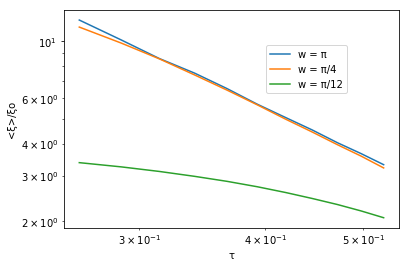

In [7]:
startT = np.pi/12
endT = np.pi/6

begin = 0
end = len(analytics)

#begin = 8
#end = 11
#this cell plots the older data sets
fig, ax = plt.subplots(1)
ax.set_xlabel("τ")
ax.set_ylabel("<ξ>/ξo")
ax = plt.loglog(np.linspace(startT,endT,len(analytics))[begin:end],analytics[begin:end])
fig.legend(('w = π','w = π/4','w = π/12'),loc = (0.65,0.65))
fig.savefig('intersite_multiple_disorder.png', dpi=400)
print(analytics)
np.polyfit(np.log(np.linspace(startT,endT,len(analytics)))[begin:end],np.log(analytics)[begin:end],1)

# Explanation of System

## Swapping Mechanism

![](1DChiralModel.png)

![](1DChiralEvolution.png)


Took 10.099294424057007 seconds.


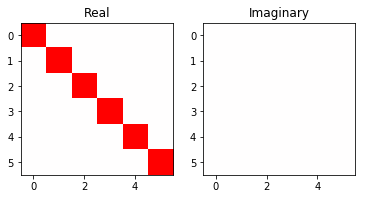

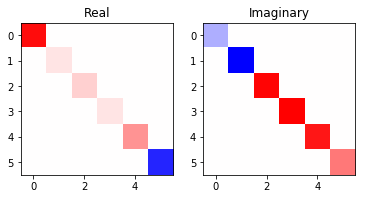

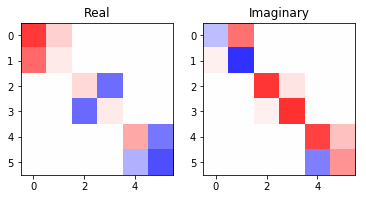

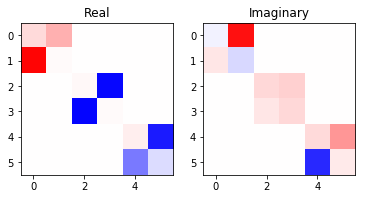

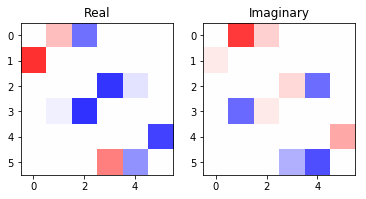

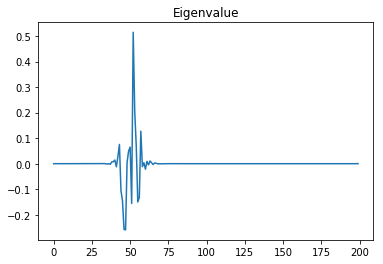

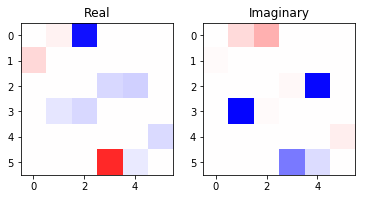

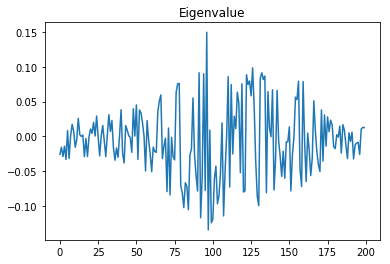

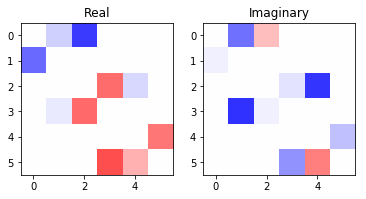

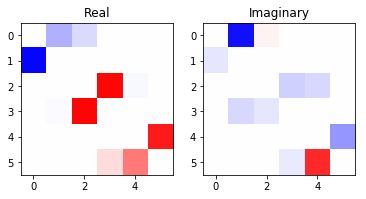

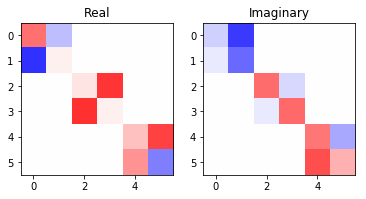

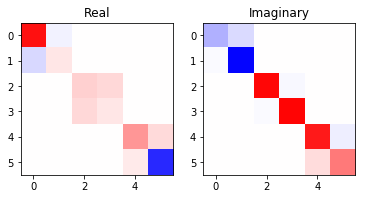

In [45]:
#TUTORIAL CELL

#this tests localization length across the whole drive for single L
#this is a single shot and more customizable simulation
#after running this, go to (or just run) the next two cells for looking at the data

#inputs are
#L is size of system (L = 500 is something like 2 seconds per step per dRealization)
#the number of disorder realizations
#each of the Steps variables is how many data points along each part of the drive to collect
#the steps are equispaced
#w controls disorder that relies on picking a random phase (-w to w)
#h is for coupling disorder (and is the fractional deviation)
#view is the amount of the unitary you wish to view

#this cell is currently set up for coupling disorder, but the functions to try other types of
#disorder are in the right place, but commented out. Most disorder is done just at the beginning

L = 200
dRealizations = 1
Steps1 = 10
Steps2 = 10
Steps3 = 10
Steps4 = 10
if Steps1: delT1 = np.pi/(2*Steps1)
if Steps2: delT2 = np.pi/(2*Steps2)
if Steps3: delT3 = np.pi/(2*Steps3)
if Steps4: delT4 = np.pi/(2*Steps4)
w = 2*np.pi
h = 0
view = 6

#these store the output data here
loclens = np.zeros((Steps1 + Steps2 + Steps3 + Steps4 , L))
quasEvals = np.zeros((Steps1 + Steps2 + Steps3 + Steps4, L))


#customize how you want your evolution to be by commenting
#and uncommenting the different function calls
#make sure you have the right function at each step of the drive!
temp = t.time()
for d in range(dRealizations):
    system = SinglePartUnitaryChain(L,w)
    system.showU(view)
    #system.randomCouplings(h) #slightly obsolete, only use if not bothering to loop return
    #system.CreateLoopReturn(h, DisordType = 0) #need this for using coupling disorder
    system.Dstep() #onsite disorder
    #system.step1D(h) #random unitary for each pair mixing the same sites as step1
    #system.step1T() #random unitary mixing the same sites as step1, but translationally invariant
    #system.stepLongD() #a unitary disorder that mixes adjacent A sites and adjacent B sites
    system.showU(view)
    for tee in range(Steps1):
        #fixing the step by step problem
        system.clearAll()
        system.U = system.UD
        #system.U = system.H3
        
        system.step1Rud(tee*delT1) #non disordered step
        
#         system.step1RudDfixed(tee*delT1) #coupling disorder
        
#         system.step1RudDfixedAlt(tee*delT1) #different coupling disorder
        
#         system.step1RudDfixedAlt2(tee*delT1) #another different coupling disorder
        
        if not (tee+1)%(Steps1//2):
            system.showU(view)
    
        system.calculateEspace(v=False,timed=False)
        loclens[tee][:] += (system.locLength()/dRealizations)[:]
        quasEvals[tee][:] += system.qEvals
    #system.inverseLongD()
    #system.stepLongD()
    #system.Dstep() #for if you wanna see if where the disorder happens matters
    for tee in range(Steps2):
        #fixing the step by step problem
        system.clearAll()
        system.U = system.UD
#         system.U = system.H3
    
        system.step1Rud()
        system.step2Rud(tee*delT2)
        
#         system.step1RudDfixed()
#         system.step2RudDfixed(tee*delT2)
        
#         system.step1RudDfixedAlt()
#         system.step2RudDfixedAlt(tee*delT2)
        
#         system.step1RudDfixedAlt2()
#         system.step2RudDfixedAlt2(tee*delT2)

#         system.step1Rud()
#         system.step2RudDfixedAlt2(tee*delT2)
        
#         system.step1Rud()
#         system.step2RudDfixed(tee*delT2)
    
        system.calculateEspace(v=False,timed=False)
        loclens[Steps1 + tee][:] += (system.locLength()/dRealizations)[:]
        quasEvals[Steps1 + tee][:] += system.qEvals
        
        if not (tee+1)%(Steps2//2):
            system.showU(view,L//7)
        
    #system.inverseDstep()
    #system.stepLongD()
    for tee in range(Steps3):
        #fixing the step by step problem
        system.clearAll()
        system.U = system.UD
#         system.U = system.H3
    
    
        system.step1Rud()
        system.step2Rud()
        system.step2Rud(tee*delT3)
        
#         system.step1RudDfixed()
#         system.step2RudDfixed(np.pi/2 + tee*delT3)
        
#         system.step1RudDfixedAlt()
#         system.step2RudDfixedAlt(np.pi/2 + tee*delT3)
        
#         system.step1RudDfixedAlt2()
#         system.step2RudDfixedAlt2(np.pi/2 + tee*delT3)
        
#         system.step1Rud()
#         system.step2RudDfixedAlt2(np.pi/2 + tee*delT3)
    
#         system.step1Rud()
#         system.step2RudDfixed(np.pi/2 + tee*delT3)


        if not (tee+1)%(Steps3//2):
            system.showU(view)


        system.calculateEspace(v=False,timed=False)
        loclens[Steps1 + Steps2 + tee][:] += (system.locLength()/dRealizations)[:]
        quasEvals[Steps1 + Steps2 + tee][:] += system.qEvals
    for tee in range(Steps4):
        #fixing the step by step problem
        system.clearAll()
        system.U = system.UD
#         system.U = system.H3

    
        system.step1Rud()
        system.step2Rud()
        system.step2Rud()
        system.step1Rud(tee*delT4)
        
#         system.step1RudDfixed()
#         system.step2RudDfixed(np.pi)
#         system.step1RudDfixed(tee*delT4)
        
#         system.step1RudDfixedAlt()
#         system.step2RudDfixedAlt(np.pi)
#         system.step1RudDfixedAlt(tee*delT4)
        
#         system.step1RudDfixedAlt2()
#         system.step2RudDfixedAlt2(np.pi)
#         system.step1RudDfixedAlt2(tee*delT4)

#         system.step1Rud()
#         system.step2RudDfixedAlt2(np.pi)
#         system.step1Rud(tee*delT4)

#         system.step1Rud()
#         system.step2RudDfixed(np.pi)
#         system.step1Rud(tee*delT4)
        
        if not (tee+1)%(Steps4//2):
            system.showU(view)
    
    
        system.calculateEspace(v=False,timed=False)
        loclens[Steps1 + Steps2 + Steps3 + tee][:] += (system.locLength()/dRealizations)[:]
        quasEvals[Steps1 + Steps2 + Steps3 + tee][:] += system.qEvals

quasEvals = quasEvals/dRealizations
print("Took " + str(t.time()-temp) + " seconds.")

C:\Users\Albert\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


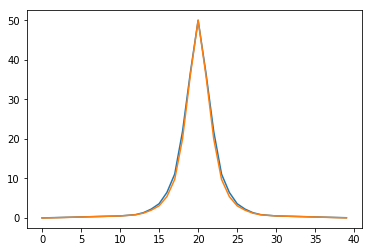

In [35]:
#this smooths and plots the previous cell's data and prints a combined localization for all states
#across the parts of the drive you ran. Each number on the x axis is a time step (which need not be the same width)

#this cell needs to be run for the 3D graph

#this is the smoothing factor (the number of states averaged together)
delL = 10
smoothLocs = np.zeros((L//delL,Steps1 + Steps2 + Steps3 + Steps4))
aveLocs = np.zeros(Steps1 + Steps2 + Steps3 + Steps4)
typLocs = np.zeros(Steps1 + Steps2 + Steps3 + Steps4)
smoothQs = np.zeros((L//delL,Steps1 + Steps2 + Steps3 + Steps4))
for tee in range(Steps1 + Steps2 + Steps3 + Steps4):
    aveLocs[tee] = np.mean(loclens[tee])
    typLocs[tee] = np.exp(np.mean(np.log(loclens[tee])))
    for l in range(L//delL):
        #choose if you smooth on max or average (doesn't seem to matter much)
        smoothLocs[l][tee] = np.mean(loclens[tee][l*delL:(l+1)*delL])
        #smoothLocs[l][tee] = max(loclens[tee][l*delL:(l+1)*delL])
        smoothQs[l][tee] = np.mean(quasEvals[tee][l*delL:(l+1)*delL])
        #smoothQs[l][tee] = max(quasEvals[tee][l*delL:(l+1)*delL])
#print(smoothLocs)

out, sub = plt.subplots(1)
sub = plt.plot(aveLocs)
sub = plt.plot(typLocs)

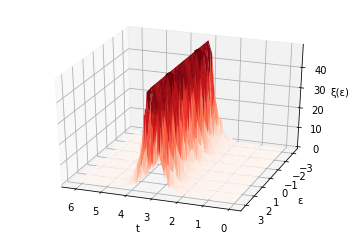

In [36]:
#prints out a pretty picture from the data of a single run through the drive
#the first of these lines makes the graph show all states
#the second is the averaged one
#only have one uncommented at a time!
Taxis, Laxis = np.meshgrid(delT2*np.arange(Steps1 + Steps2 + Steps3 + Steps4), (2*np.pi*np.arange(-(L)//2,(L)//2)/(L)))
#Taxis, Laxis = np.meshgrid(delT2*np.arange(Steps1 + Steps2 + Steps3 + Steps4), (2*np.pi*np.arange(-(L//delL)//2,(L//delL)//2)/(L//delL)))
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')

#same with these two
ax.plot_surface(Taxis,np.transpose(quasEvals), np.transpose(loclens), linewidth=0, cmap = plt.cm.Reds)
#ax.plot_surface(Taxis,Laxis, np.transpose(loclens), linewidth=0, cmap = plt.cm.Reds)
#ax.plot_surface(Taxis,smoothQs, smoothLocs, linewidth=0, cmap = plt.cm.Reds)

#the two numbers here are pitch and yaw respectively (vertical angle and turned angle)
ax.set_xlabel("t")
ax.set_ylabel("ε")
ax.set_zlabel("ξ(ε)")
ax.view_init(30, 110)
#fig.savefig('simple_onsite_disorder_evolution.png', dpi=400)
plt.show()